# ***Checking for created data which is used in this notebook as internet is disabled***

In [1]:
import os
os.listdir('../input/necessary')

['timm-0.3.2-py3-none-any.whl', 'tf_efficientnet_b7_ns-1dbc32de.pth']

*Installing TIMM as it is not pre-installed*

In [2]:
!pip install '../input/necessary/timm-0.3.2-py3-none-any.whl'

Processing /kaggle/input/necessary/timm-0.3.2-py3-none-any.whl


*Importing necessary libraries*

In [3]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *

*Setting seed (any desired number)*

In [4]:
set_seed(12)

*Some basic stuff*

In [5]:
dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [6]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [7]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


*Image processing*

In [8]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train_images'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(5)

,label,path
0,3,../input/cassava-leaf-disease-classification/train_images/357815961.jpg
1,3,../input/cassava-leaf-disease-classification/train_images/2096389137.jpg
2,3,../input/cassava-leaf-disease-classification/train_images/295042633.jpg
3,3,../input/cassava-leaf-disease-classification/train_images/3902258534.jpg
4,4,../input/cassava-leaf-disease-classification/train_images/61074408.jpg


*Total number of train samples*

In [9]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 21397 images


*Distribution of train images*

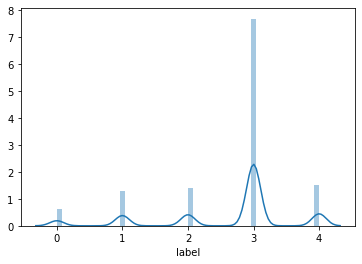

In [10]:
import seaborn as sns
sns.distplot(train_df['label'])

In [11]:
from PIL import Image

sample = Image.open(train_df['path'][1])
width, height = sample.size
print(width,height) 

800 600


*A sample drawn from our dataset*

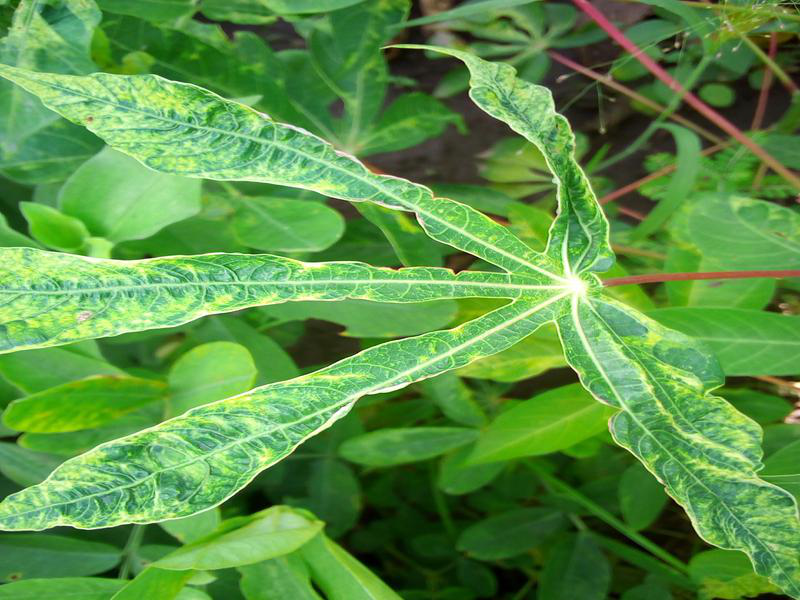

In [12]:
sample

# **Let's load data**

In [13]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
batchsize=32

**Let's load data**
*let's load data using dataloaders of FastAI*

In [14]:
dataloader = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=batchsize, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

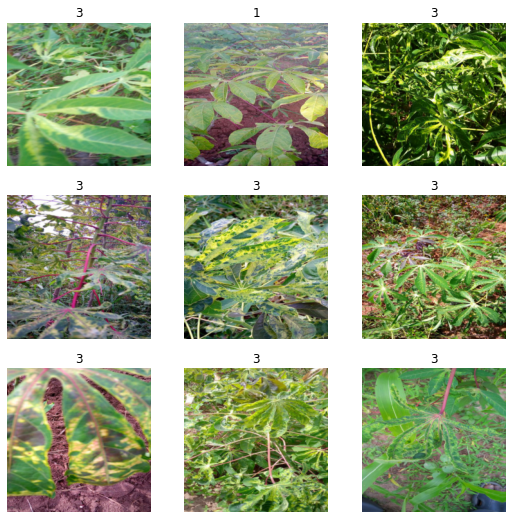

In [15]:
dataloader.show_batch()

**Model Training**

Here we used Learner as trainer class.
It gets the data, creates model, optimizers, loss function

In [16]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [17]:
def timm_learner(dataloader, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dataloader` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dataloader)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dataloader.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dataloader, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

*moving the files to root path of pytorch*

In [18]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/necessary/tf_efficientnet_b7_ns-1dbc32de.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth'

In [19]:
learn = timm_learner(dataloader, 
                    'tf_efficientnet_b7_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()

*To find perfect learning rate*

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=5.754399353463668e-06)

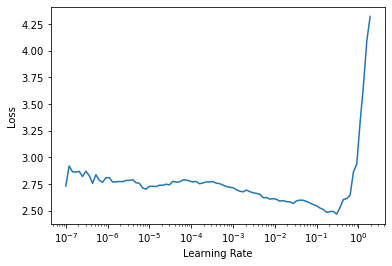

In [20]:
learn.lr_find()

*The best way to train a model is to train the frozen pretrained model for a single epoch and then train the whole pretrained model for several epochs. The Ranger optimizer performs best with a flat+cosine annealing learning rate schedule. We will now train the frozen model for one epoch*

*According to graph, the lowest loss is at 10^0 -10^-1 bucket*

In [21]:
learn.freeze()
learn.fit_flat_cos(1,1e-1, wd=0.5, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,1.102256,0.949195,0.719794,07:55


In [22]:
learn.save('learn_after_one_epoch')

Path('models/learn_after_one_epoch.pth')

In [23]:
learn = learn.load('learn_after_one_epoch')

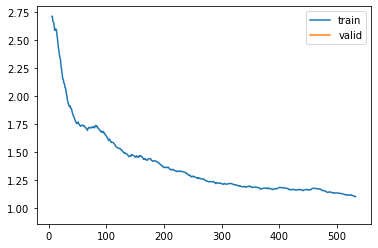

In [24]:
learn.recorder.plot_loss()

*Unfreezing the model to find perfect learning rate*

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=9.12010818865383e-07)

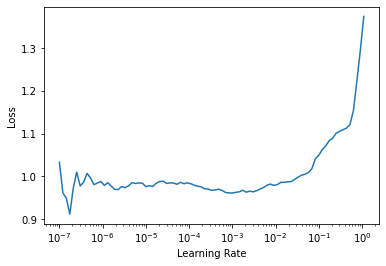

In [25]:
learn.unfreeze()
learn.lr_find()

*According to graph, the lowest loss is at 10^-3 -10^-2 bucket*

*Let's train for 50 epoch*

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(20,2e-3,pct_start=0,cbs=[MixUp()])

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = learn.to_native_fp32()

In [ ]:
learn.save('learn_after_fifty_epoch')

*Export if required*

In [ ]:
learn.export()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df.head()

In [ ]:
ss = sample_df.copy()
ss['path'] = ss['image_id'].map(lambda x:dataset_path/'test_images'/x)
ss = ss.drop(columns=['image_id'])
test_dl = dataloader.test_dl(ss)

In [ ]:
test_dl.show_batch()

*Making predictions and submissions*

In [ ]:
preds, _ = learn.tta(dl=test_dl, n=8, beta=0)

In [ ]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [ ]:
sample_df.to_csv('submission.csv',index=False)